![](../storage/banners/46_propulsion.png)

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sympy import *

M = 5.972e24
G = 6.6743e-11
mu = M * G
R_orb = 7000e3
w_0 = np.sqrt(mu/R_orb**3)

### Управление как в статье Izzo

In [2]:
def A(w: float, t: float):
    return np.array([[1, 0, 6*w*t - 6*np.sin(w*t)],
                     [0, np.cos(w*t), 0],
                     [1, 0, 4 - 3*np.cos(w*t)]])

def B(w: float, t: float):
    return np.array([[4*np.sin(w*t) - 3*w*t, 0, 2 - 2*np.cos(w*t)],
                     [0, np.sin(w*t), 0],
                     [2*np.cos(w*t) - 2, 0, np.sin(w*t)]]) / w

def v_gath(n: int, w: float, t: float, tau: float, xi, r):
    tmp = np.zeros(3)
    B_1 = np.linalg.inv(B(w=w, t=t))
    B1 = np.linalg.inv(B(w=w, t=(tau - t)))
    for i in range(n):
        tmp += B_1 @ xi[i]
    return tmp - B1 @ A(w=w, t=(tau - t)) @ np.array(r)

def a_orb(w: float, v, r):
    return [-2*w*v[2],
            -w**2*r[1],
            3*w**2*r[2] + 2*w*v[0]]

def clip(a, top, bot):
    if a > top:
        return top
    if a < bot:
        return bot
    return a

In [28]:
dt = 1.
tau = 3500.
amax = 1e-2

# xi = [np.array([-10., -20., 30.])]
xi = [np.array([24.380303062296115, -8.896811913254963, -9.769582819911278])]
t = [0.]
x = [10.]
y = [11.]
z = [12.]
vx = [- 2 * z[0] * w_0]
vy = [0.000]
vz = [0.000]
ax = [0.000]
ay = [0.000]
az = [0.000]
x_ = x.copy()
y_ = y.copy()
z_ = z.copy()
vx_ = vx.copy()
vy_ = vy.copy()
vz_ = vz.copy()

for i in range(int(round(tau / dt)) - 2):
    t += [(i+1) * dt]
    x += [x[-1] + vx[-1] * dt]
    y += [y[-1] + vy[-1] * dt]
    z += [z[-1] + vz[-1] * dt]
    tmp = v_gath(n=1, w=w_0, t=t[-1], tau=tau, xi=xi, r=[x[-1], y[-1], z[-1]])
    a_ = a_orb(w=w_0, v=[vx[-1], vy[-1], vz[-1]], r=[x[-1], y[-1], z[-1]])
    a = (tmp - np.array([vx[-1], vy[-1], vz[-1]])) / dt
    a -= a_
    a = a if np.linalg.norm(a) < amax else a * amax / np.linalg.norm(a)
    ax += [a[0]]
    ay += [a[1]]
    az += [a[2]]
    vx += [vx[-1] + (ax[-1] + a_[0]) * dt]
    vy += [vy[-1] + (ay[-1] + a_[1]) * dt]
    vz += [vz[-1] + (az[-1] + a_[2]) * dt]
    
    x_ += [x_[-1] + vx_[-1] * dt]
    y_ += [y_[-1] + vy_[-1] * dt]
    z_ += [z_[-1] + vz_[-1] * dt]
    a_ = a_orb(w=w_0, v=[vx_[-1], vy_[-1], vz_[-1]], r=[x_[-1], y_[-1], z_[-1]])
    vx_ += [vx_[-1] + a_[0] * dt]
    vy_ += [vy_[-1] + a_[1] * dt]
    vz_ += [vz_[-1] + a_[2] * dt]
print(f"r_no_fuel = [{x_[-1]}, {y_[-1]}, {z_[-1]}]")

r_no_fuel = [24.380303062296115, -8.896811913254963, -9.769582819911278]


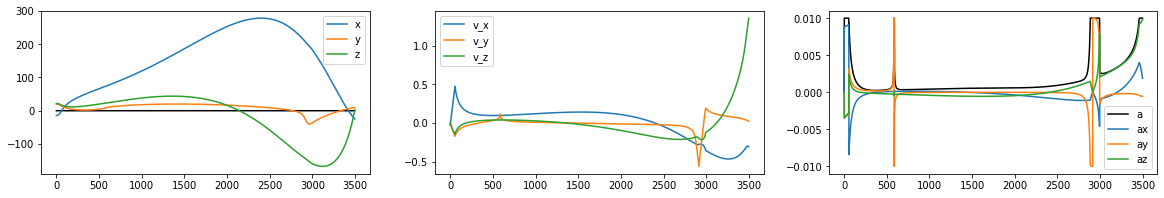

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(20, 3))
axs[1].plot(t, vx, label='v_x')
axs[1].plot(t, vy, label='v_y')
axs[1].plot(t, vz, label='v_z')
axs[1].legend()
axs[0].plot(t, [0 for _ in range(len(x))], 'k')
axs[0].plot(t, [x[i]-xi[0][0] for i in range(len(x))], label='x')
axs[0].plot(t, [y[i]-xi[0][1] for i in range(len(y))], label='y')
axs[0].plot(t, [z[i]-xi[0][2] for i in range(len(z))], label='z')
axs[0].legend()
axs[2].plot(t, [np.sqrt(ax[i]**2+ay[i]**2+az[i]**2) for i in range(len(ax))], 'k', label='a')
axs[2].plot(t, ax, label='ax')
axs[2].plot(t, ay, label='ay')
axs[2].plot(t, az, label='az')
axs[2].legend()
plt.show()

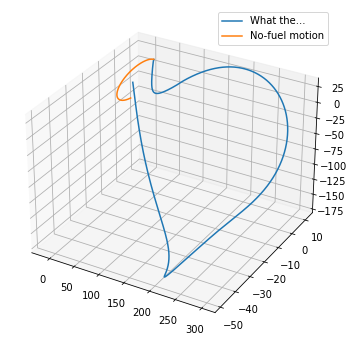

In [30]:
axes = plt.figure(figsize=(6, 6)).add_subplot(projection='3d')
axes.plot(x, y, z, label='What the...')
axes.plot(x_, y_, z_, label='No-fuel motion')
axes.legend()
plt.show()

### Обычное сведение коэффициентов хку

In [24]:
def get_c_hkw(r, v, w):
    return [2*r[2] + v[0]/w, v[2]/w, -3*r[2] - 2*v[0]/w, r[0] - 2*v[2]/w, v[1]/w, r[1]]

def r_hkw(C, w, t):
    return np.array([-3 * C[0] * w * t + 2 * C[1] * np.cos(w * t) - 2 * C[2] * np.sin(w * t) + C[3],
                     C[5] * np.cos(w * t) + C[4] * np.sin(w * t),
                     2 * C[0] + C[2] * np.cos(w * t) + C[1] * np.sin(w * t)])

def v_hkw(C, w, t):
    return np.array([-3 * C[0] * w - 2 * w * C[1] * np.sin(w * t) - 2 * w * C[2] * np.cos(w * t),
                     w * C[4] * np.cos(w * t) - w * C[5] * np.sin(w * t),
                     -w * C[2] * np.sin(w * t) + w * C[1] * np.cos(w * t)])

def a_orb(w: float, v, r):
    return [-2*w*v[2],
            -w**2*r[1],
            3*w**2*r[2] + 2*w*v[0]]

In [302]:
dt = 1.
tau = 3500.
amax = 1e-4
k_r = 1. #1e-14
k_v = 1e1 #1e-12
k_i = 3e-4

xi = [np.array([24.380303062296115, -8.896811913254963, -9.769582819911278])]
vi = [np.array([0.02106307217412556, 0.006978602217994925, 0.007675035564327966])]
C_target = np.array(get_c_hkw(r=xi[0], v=vi[0], w=w_0))

t = [0.]
x = [10.]
y = [11.]
z = [12.]
vx = [- 2 * z[0] * w_0]
vy = [0.000]
vz = [0.000]
ax = [0.000]
ay = [0.000]
az = [0.000]
x_ = x.copy()
y_ = y.copy()
z_ = z.copy()
vx_ = vx.copy()
vy_ = vy.copy()
vz_ = vz.copy()

# Ошибка
vy = [0.015]
vz = [-0.001]
x__ = x.copy()
y__ = y.copy()
z__ = z.copy()
vx__ = vx.copy()
vy__ = vy.copy()
vz__ = vz.copy()

integ = 0.

for i in range(int(round(tau / dt)) - 2):
    t += [(i+1) * dt]
    x += [x[-1] + vx[-1] * dt]
    y += [y[-1] + vy[-1] * dt]
    z += [z[-1] + vz[-1] * dt]
    a_ = a_orb(w=w_0, v=[vx[-1], vy[-1], vz[-1]], r=[x[-1], y[-1], z[-1]])
    
    '''C = get_c_hkw(r=[x[-1], y[-1], z[-1]], v=[vx[-1], vy[-1], vz[-1]], w=w_0)    
    r_after = r_hkw(C, w=w_0, t=tau-t[-1])
    v_after = v_hkw(C, w=w_0, t=tau-t[-1])
    C_after = get_c_hkw(r=r_after, v=v_after, w=w_0)
    dC = np.array(C_after) - C_target
    print(f"C={C_after}")'''
    
    r_target = r_hkw(C_target, w=w_0, t=t[-1]-tau)
    v_target = v_hkw(C_target, w=w_0, t=t[-1]-tau)
    integ += (r_target - np.array([x[-1], y[-1], z[-1]])) * dt
    a = - k_i * integ - k_r * (r_target - np.array([x[-1], y[-1], z[-1]])) - k_v * (v_target - np.array([vx[-1], vy[-1], vz[-1]]))
    a = -a
    
    a = a if np.linalg.norm(a) < amax else a * amax / np.linalg.norm(a)
    ax += [a[0]]
    ay += [a[1]]
    az += [a[2]]
    vx += [vx[-1] + (ax[-1] + a_[0]) * dt]
    vy += [vy[-1] + (ay[-1] + a_[1]) * dt]
    vz += [vz[-1] + (az[-1] + a_[2]) * dt]
    
    x_ += [x_[-1] + vx_[-1] * dt]
    y_ += [y_[-1] + vy_[-1] * dt]
    z_ += [z_[-1] + vz_[-1] * dt]
    a_ = a_orb(w=w_0, v=[vx_[-1], vy_[-1], vz_[-1]], r=[x_[-1], y_[-1], z_[-1]])
    vx_ += [vx_[-1] + a_[0] * dt]
    vy_ += [vy_[-1] + a_[1] * dt]
    vz_ += [vz_[-1] + a_[2] * dt]
    x__ += [x__[-1] + vx__[-1] * dt]
    y__ += [y__[-1] + vy__[-1] * dt]
    z__ += [z__[-1] + vz__[-1] * dt]
    a__ = a_orb(w=w_0, v=[vx__[-1], vy__[-1], vz__[-1]], r=[x__[-1], y__[-1], z__[-1]])
    vx__ += [vx__[-1] + a__[0] * dt]
    vy__ += [vy__[-1] + a__[1] * dt]
    vz__ += [vz__[-1] + a__[2] * dt]
print(f"r_no_fuel = [{x_[-1]}, {y_[-1]}, {z_[-1]}]")
print(f"v_no_fuel = [{vx_[-1]}, {vy_[-1]}, {vz_[-1]}]")

r_no_fuel = [24.380303062296115, -8.896811913254963, -9.769582819911278]
v_no_fuel = [0.02106307217412556, 0.006978602217994925, 0.007675035564327966]


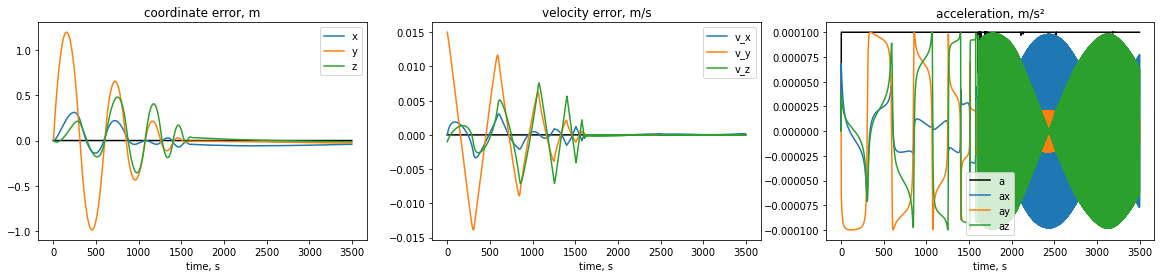

In [318]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
axs[1].plot(t, [0 for _ in range(len(vx))], 'k')
axs[1].plot(t, [vx[i]-vx_[i] for i in range(len(vx))], label='v_x')
axs[1].plot(t, [vy[i]-vy_[i] for i in range(len(vy))], label='v_y')
axs[1].plot(t, [vz[i]-vz_[i] for i in range(len(vz))], label='v_z')
axs[1].set_xlabel("time, s")
axs[1].set_title("velocity error, m/s")
axs[1].legend()
axs[0].plot(t, [0 for _ in range(len(x))], 'k')
axs[0].plot(t, [x[i]-x_[i] for i in range(len(x))], label='x')
axs[0].plot(t, [y[i]-y_[i] for i in range(len(y))], label='y')
axs[0].plot(t, [z[i]-z_[i] for i in range(len(z))], label='z')
axs[0].set_xlabel("time, s")
axs[0].set_title("coordinate error, m")
axs[0].legend()
axs[2].plot(t, [np.sqrt(ax[i]**2+ay[i]**2+az[i]**2) for i in range(len(ax))], 'k', label='a')
axs[2].plot(t, ax, label='ax')
axs[2].plot(t, ay, label='ay')
axs[2].plot(t, az, label='az')
axs[2].set_xlabel("time, s")
axs[2].set_title("acceleration, m/s²")
axs[2].legend()
plt.show()

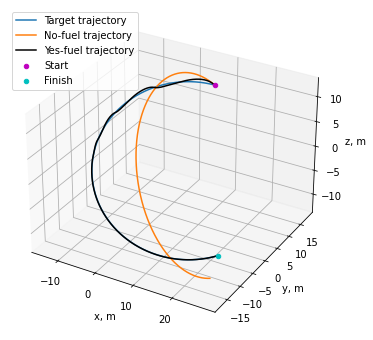

In [313]:
axes = plt.figure(figsize=(6, 6)).add_subplot(projection='3d')
axes.plot(x_, y_, z_, label='Target trajectory')
axes.plot(x__, y__, z__, label='No-fuel trajectory')
axes.plot(x, y, z, 'k', label='Yes-fuel trajectory')
axes.scatter(x_[0], y_[0], z[0], c='m', label='Start')
axes.scatter(x_[-1], y_[-1], z[-1], c='c', label='Finish')
axes.legend()
axes.set_xlabel("x, m")
axes.set_ylabel("y, m")
axes.set_zlabel("z, m")
plt.show()

## Управление без обратной связи - исследование выпуклости

In [17]:
from sympy.solvers.ode.systems import dsolve_system

In [20]:
t = var('t', real=True)
w, T, a1x, a1y, a1z, a2x, a2y, a2z = var('w T a_1^x a_1^y a_1^z a_2^x a_2^y a_2^z', constant=True, real=True)
x0, y0, z0, vx0, vy0, vz0 = var('x_0 y_0 z_0 v^x_0 v^y_0 v^z_0', real=True, constant=True)
x = Function('x')(t)
y = Function('y')(t)
z = Function('z')(t)
vx = Function('v_x')(t)
vy = Function('v_y')(t)
vz = Function('v_z')(t)
ax = a1x * t + a2x * (T - t)
ay = a1y * t + a2y * (T - t)
az = a1z * t + a2z * (T - t)
equations = {Eq(x.diff(t), vx),
             Eq(y.diff(t), vy),
             Eq(z.diff(t), vz),
             Eq(vx.diff(t), ax - 2 * w * vz),
             Eq(vy.diff(t), ay - w**2 * y),
             Eq(vz.diff(t), az + 3 * w**2 * z + 2 * w * vx)
            }

'equations = {Eq(x(t).diff(t), vx(t)),\n             Eq(y(t).diff(t), vy(t)),\n             Eq(z(t).diff(t), vz(t)),\n             Eq(vx(t).diff(t), ax - 2 * w * vz(t)),\n             Eq(vy(t).diff(t), ay - w**2 * y(t)),\n             Eq(vz(t).diff(t), az + 3 * w**2 * z(t) + 2 * w * vx(t))\n            }'

In [22]:
anw = dsolve(equations)  # , ics={x(0): x0, y(0): y0, z(0): z0, vx(0): vx0, vy(0): vy0, vz(0): vz0})

In [30]:
anw[0]

Eq(z(t), -2*C1/(3*w) + C2*sin(t*w)/(2*w) - C3*cos(t*w)/(2*w) + 2*T*a_2^x*t/w - 2*T*a_2^x*Piecewise((-cos(t*w)/w, Ne(w, 0)), (0, True))*sin(t*w)/w + 2*T*a_2^x*cos(t*w)*Integral(sin(t*w)**2/cos(t*w), t)/w - 2*T*a_2^x*cos(t*w)*Integral(1/cos(t*w), t)/w + T*a_2^z*Piecewise((sin(t*w)/w, Ne(w, 0)), (t, True))*sin(t*w)/w - T*a_2^z*cos(t*w)*Integral(sin(t*w), t)/w + t**2*(a_1^x - a_2^x)/w + 2*t*(a_1^x - a_2^x)*sin(t*w)*cos(t*w)/w**2 + t*(a_1^z - a_2^z)*sin(t*w)**2/w**2 - 2*(a_1^x - a_2^x)*cos(t*w)*Integral(t/cos(t*w), t)/w + 2*(a_1^x - a_2^x)*cos(t*w)*Integral(t*sin(t*w)**2/cos(t*w), t)/w - (a_1^z - a_2^z)*cos(t*w)*Integral(t*sin(t*w), t)/w - 2*(a_1^x - a_2^x)*sin(t*w)**2/w**3 + (a_1^z - a_2^z)*sin(t*w)*cos(t*w)/w**3)

# БЛЯДЬ

In [31]:
t = var('t', real=True)
w, T, a1x, a1y, a1z, a2x, a2y, a2z = var('w T a_1^x a_1^y a_1^z a_2^x a_2^y a_2^z', constant=True, real=True)
x0, y0, z0, vx0, vy0, vz0 = var('x_0 y_0 z_0 v^x_0 v^y_0 v^z_0', real=True, constant=True)
x, y, z, vx, vy, vz = symbols("x y z v_x v_y v_z", cls=Function)
ax = a1x * t + a2x * (T - t)
ay = a1y * t + a2y * (T - t)
az = a1z * t + a2z * (T - t)
equations = {Eq(x(t).diff(t), vx(t)),
             Eq(y(t).diff(t), vy(t)),
             Eq(z(t).diff(t), vz(t)),
             Eq(vx(t).diff(t), ax - 2 * w * vz(t)),
             Eq(vy(t).diff(t), ay - w**2 * y(t)),
             Eq(vz(t).diff(t), az + 3 * w**2 * z(t) + 2 * w * vx(t))
            }

In [32]:
anw = dsolve_system(equations, ics={x(0): x0, y(0): y0, z(0): z0, vx(0): vx0, vy(0): vy0, vz(0): vz0})

In [34]:
anw[0][0]

Eq(z(t), 2*v^x_0/w + 4*z_0 + (v^z_0/w + (T*(2*a_2^x*Integral(sin(t*w), (t, 0)) - a_2^z*Integral(cos(t*w), (t, 0))) + 2*a_1^x*Integral(t*sin(t*w), (t, 0)) - a_1^z*Integral(t*cos(t*w), (t, 0)) - 2*a_2^x*Integral(t*sin(t*w), (t, 0)) + a_2^z*Integral(t*cos(t*w), (t, 0)))/w)*sin(t*w) - (2*v^x_0/w + 3*z_0 + (T*(2*a_2^x*(Integral(sin(t*w)**2/cos(t*w), (t, 0)) - Integral(1/cos(t*w), (t, 0))) - a_2^z*Integral(sin(t*w), (t, 0))) - 2*a_1^x*(Integral(t/cos(t*w), (t, 0)) - Integral(t*sin(t*w)**2/cos(t*w), (t, 0))) - a_1^z*Integral(t*sin(t*w), (t, 0)) + 2*a_2^x*(Integral(t/cos(t*w), (t, 0)) - Integral(t*sin(t*w)**2/cos(t*w), (t, 0))) + a_2^z*Integral(t*sin(t*w), (t, 0)))/w)*cos(t*w) - 2*(T*a_2^x*Integral(1, (t, 0)) + a_1^x*Integral(t, (t, 0)) - a_2^x*Integral(t, (t, 0)))/w + sin(t*w)*Integral(-2*T*a_2^x*sin(t*w) + T*a_2^z*cos(t*w) - 2*a_1^x*t*sin(t*w) + a_1^z*t*cos(t*w) + 2*a_2^x*t*sin(t*w) - a_2^z*t*cos(t*w), t)/w - cos(t*w)*Integral(-2*T*a_2^x*sin(t*w)**2/cos(t*w) + 2*T*a_2^x/cos(t*w) + T*a_2^z*si

# мама

In [36]:
tmp_0 = anw[0][0].simplify()
tmp_0

Eq(z(t), (2*T*a_2^x*t - t**2*(-a_1^x + a_2^x) + 2*v^x_0 + 4*w*z_0 + (2*T*a_2^x*Piecewise((-1/w, Ne(w, 0)), (0, True)) - a_1^z/w**2 + a_2^z/w**2 + v^z_0)*sin(t*w) - (-T*a_2^z*Piecewise((-1/w, Ne(w, 0)), (0, True)) - 2*a_1^x*(Integral(t/cos(t*w), (t, 0)) - Integral(t*sin(t*w)**2/cos(t*w), (t, 0))) + 2*a_2^x*(Integral(t/cos(t*w), (t, 0)) - Integral(t*sin(t*w)**2/cos(t*w), (t, 0))) + 2*v^x_0 + 3*w*z_0)*cos(t*w) + (-2*T*a_2^x*Piecewise((-cos(t*w)/w, Ne(w, 0)), (0, True)) + T*a_2^z*Piecewise((sin(t*w)/w, Ne(w, 0)), (t, True)) - 2*a_1^x*(-t*cos(t*w)/w + sin(t*w)/w**2) + a_1^z*(t*sin(t*w)/w + cos(t*w)/w**2) + 2*a_2^x*(-t*cos(t*w)/w + sin(t*w)/w**2) - a_2^z*(t*sin(t*w)/w + cos(t*w)/w**2))*sin(t*w) - (-Integral(-4*T*a_2^x/cos(t*w), t) - Integral(-4*a_1^x*t/cos(t*w), t) - Integral(4*a_2^x*t/cos(t*w), t) - Integral(4*T*a_2^x*sin(t*w)**2/cos(t*w), t) - Integral(-T*a_2^z*sin(2*t*w)/cos(t*w), t) - Integral(4*a_1^x*t*sin(t*w)**2/cos(t*w), t) - Integral(-a_1^z*t*sin(2*t*w)/cos(t*w), t) - Integral(-4*a_

# ХОРОШО уговорил давай полиномом

In [37]:
t = var('t', real=True)
w, T, a1x, a1y, a1z, a2x, a2y, a2z = var('w T a_1^x a_1^y a_1^z a_2^x a_2^y a_2^z', constant=True, real=True)
x0, y0, z0, vx0, vy0, vz0 = var('x_0 y_0 z_0 v^x_0 v^y_0 v^z_0', real=True, constant=True)
x, y, z, vx, vy, vz = symbols("x y z v_x v_y v_z", cls=Function)
ax = a1x + a2x * t
ay = a1y + a2y * t
az = a1z + a2z * t
equations = {Eq(x(t).diff(t), vx(t)),
             Eq(y(t).diff(t), vy(t)),
             Eq(z(t).diff(t), vz(t)),
             Eq(vx(t).diff(t), ax - 2 * w * vz(t)),
             Eq(vy(t).diff(t), ay - w**2 * y(t)),
             Eq(vz(t).diff(t), az + 3 * w**2 * z(t) + 2 * w * vx(t))
            }

In [38]:
anw = dsolve_system(equations, ics={x(0): x0, y(0): y0, z(0): z0, vx(0): vx0, vy(0): vy0, vz(0): vz0})

In [39]:
anw[0][0]

Eq(v_z(t), (2*a_1^x*Integral(sin(t*w), (t, 0)) + a_1^z*(Integral(sin(t*w)**2/cos(t*w), (t, 0)) - Integral(1/cos(t*w), (t, 0))) + 2*a_2^x*Integral(t*sin(t*w), (t, 0)) - a_2^z*(Integral(t/cos(t*w), (t, 0)) - Integral(t*sin(t*w)**2/cos(t*w), (t, 0))) + v^z_0)*cos(t*w) - (2*a_1^x*Integral(cos(t*w), (t, 0)) + a_1^z*Integral(sin(t*w), (t, 0)) + 2*a_2^x*Integral(t*cos(t*w), (t, 0)) + a_2^z*Integral(t*sin(t*w), (t, 0)) - 2*v^x_0 - 3*w*z_0)*sin(t*w) + sin(t*w)*Integral(2*a_1^x*cos(t*w) + a_1^z*sin(t*w) + 2*a_2^x*t*cos(t*w) + a_2^z*t*sin(t*w), t) + cos(t*w)*Integral(-2*a_1^x*sin(t*w) - a_1^z*sin(t*w)**2/cos(t*w) + a_1^z/cos(t*w) - 2*a_2^x*t*sin(t*w) - a_2^z*t*sin(t*w)**2/cos(t*w) + a_2^z*t/cos(t*w), t))